### What is Reinforcement Learning?
RL is a machine learning technique that trains an agent to make decisions to achieve the most optimal results. It mimics the trial-and-error learning process that humans use to achieve their goals.

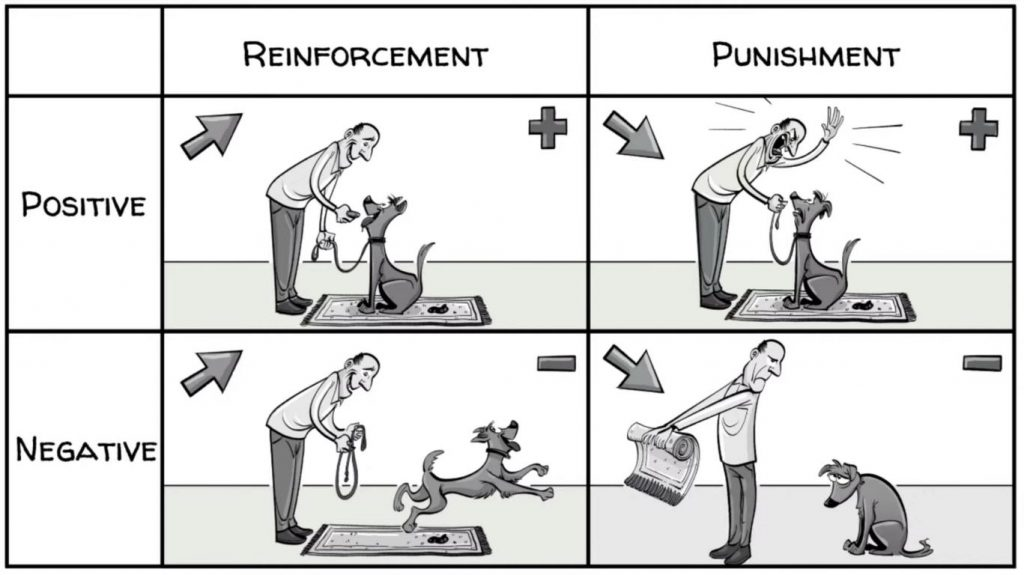

### Observation Space
Including all cells of the grid in the observation space would make it computationally impossible to train the agent. Instead of that, we're going to extract some meaningful features and use them to train the agent:
- The direction of the snack.
- Whether the other Snake is near me (distance less than a defined radius) or not.
- The direction of the other Snake.
- The direction of the rest of my body.
- Whether I am near any border lines or not (if the distance from any border line is less than 2).
- The direction of the border line near me.


#### How to determine the direction of a target based on the currecnt location of the Snake?
We have the cartesian coordinates of our Snake and that target. Here's how to code to find the direction:
```python
    dx = target.x - snake.head.x
    dy = target.y - snake.head.y
    if dx >= 0:
        if abs(dx) >= abs(dy):
            return 0
    else:
        if abs(dx) >= abs(dy):
            return 2
    if dy >= 0:
        if abs(dy) >= abs(dx):
            return 1
    else:
        if abs(dy) >= abs(dx):
            return 3
```

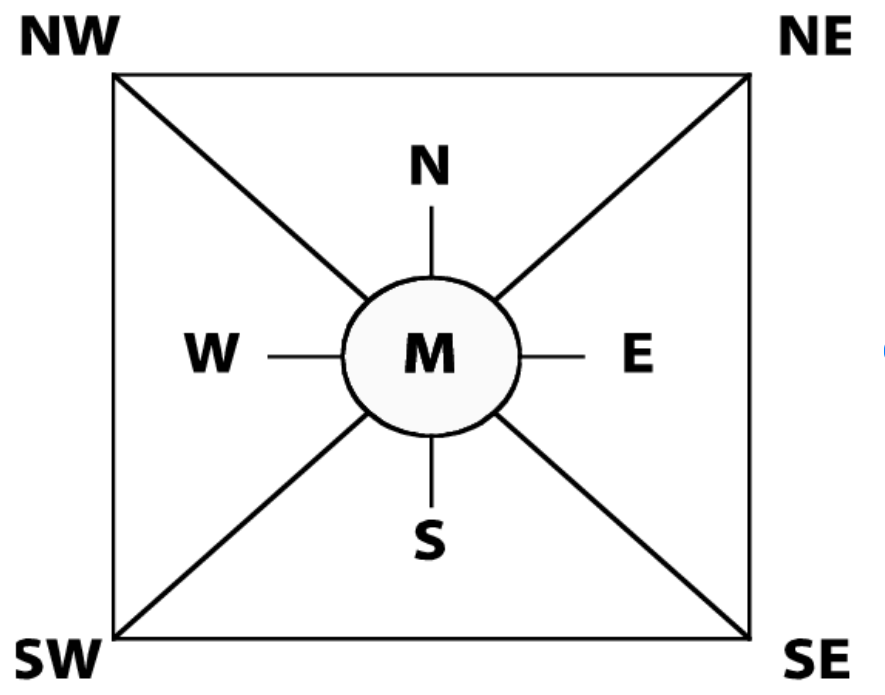

#### Direction of the Snack
The snack is in one of these areas and the Snake could reach it by moving in the direction of the snack.

#### Direction of the other Snake
First, a circle with a defined radius (2 or 3) is drawn around the head of our Snake. Then, the circle is broken down into four symmetric areas and finally, the area with the minimum number of cells occupied by the other Snake's body is chosen. This approach helps to avoid hitting the other Snake's body. Here's the code to do so:

Iterate through neighbor cells:
```python
    d = [i for i in range(-r, r+1)]
    is_in_region = {i: 0 for i in range(1, 5)}
    for dx in d:
        for dy in d:
```
Check if the cell is out of the circle :
```python
    if (dx == 0 and dy == 0) or (abs(dx) + abs(dy) > r):
        continue
```
Check if the cell is occupied by any of the target cubes using a ```if``` statement:
```python          
    x, y = self.head.pos
    x += dx
    y += dy
    if (x, y) in cubes:
```       
Determine the region of each cube:
```python  
    if dx >= 0:
        if abs(dx) >= abs(dy):
            is_in_region[1] += 1
    if dx <= 0:
        if abs(dx) >= abs(dy):
            is_in_region[3] += 1
    if dy >= 0:
        if abs(dy) >= abs(dx):
            is_in_region[2] += 1
    if dy <= 0:
        if abs(dy) >= abs(dx):
            is_in_region[4] += 1
```
Find the region with minimum occupied cells:
```python
    if is_in_region[1] == 0 and is_in_region[2] == 0 and \
        is_in_region[3] == 0 and is_in_region[4] == 0:
        return 0
    else:
        return min(is_in_region, key=is_in_region.get)
```

#### Direction of rest of the Snake' Body
The process is similar to finding the direction of the other Snake' body

#### Closeness to Border Lines
Check if there is any border line near the Snake:
```python
    x, y = self.head.pos
    d = distance_to_keep_from_borders
    lb, ub = 0 + WALLS_THICKNESS, (ROWS - 1) - WALLS_THICKNESS 
    if (x < lb + d)  | \
        (y < lb + d) | \
        (x > ub - d) | \
        (y > ub - d):
        return 1
    return 0
```
Find the direction of the possible border line near to the Snake:
```python
    if x < lb + d:
        return 1
    if y < lb + d:
        return 4
    if x > ub - d:
        return 3
    if y > ub - d:
        return 2
    return 0
```

#### Create State Space
By combinig all the extracted features, we create a meaningful state space to help the Snake form the Q-table.
```python
    states = []
    states.append(self.create_snack_state(snack=snack))
    states.append(self.create_neighbor_cells_state(r=RADIUS, cubes=list(map(lambda z: z.pos, other_snake.body))))
    states.append(self.create_neighbor_cells_state(r=RADIUS, cubes=list(map(lambda z: z.pos, self.body[1:]))))
    states.append(int(self.is_near_borders(distance_to_keep_from_borders=1)))
    states.append(self.create_border_state(distance_to_keep_from_borders=1))
    return states
```

### Reward Fucntion
First of all we need to assign a reward for different situations.
```python
    DEATH_REWARD = -1000
    SNACK_REWARD = 500
    WIN_REWARD = 500
    TIE_REWARD = 0
```
After that we'll write a function to calculate reward of each state. I'll break down the code and explain each part separatly.

Initializing variables at the beggining.
```python
    reward = 0
    win_self, win_other = False, False
    ate_snack, died_border, died_snake = False, False, False
```
Punish the snake for getting out of the border lines.
```python
    if self.check_out_of_board(point=self.head.pos):
        self.reset((random.randint(3, 18), random.randint(3, 18)))
        reward += DEATH_REWARD
        died_border = True
        win_other = True
```
Reward the snake for eating snack
```python
    if self.head.pos == snack.pos:
        self.addCube()
        snack = Cube(randomSnack(ROWS, self), color=(0, 255, 0))
        ate_snack = True
        reward += SNACK_REWARD
```
Punish the snake for hitting itself
```python
    if self.head.pos in list(map(lambda z: z.pos, self.body[1:])):    
        died_snake = True
        self.reset((random.randint(3, 18), random.randint(3, 18)))
        reward += DEATH_REWARD
        win_other = True
```
Punish the snake for hitting the other snake' body
```python
    if self.head.pos in list(map(lambda z: z.pos, other_snake.body)):
        if self.head.pos != other_snake.head.pos:
            reward += DEATH_REWARD
            died_snake = True
            win_other = True
```
When two snakes hit each other on the head. In this case the shorter snake will die.
```python
    if len(self.body) > len(other_snake.body):
        other_snake.reset((random.randint(3, 18), random.randint(3, 18)))
        reward += WIN_REWARD
        win_self = True
    elif len(self.body) == len(other_snake.body):
        reward += TIE_REWARD
    else:
        self.reset((random.randint(3, 18), random.randint(3, 18)))
        reward += DEATH_REWARD
        died_snake = True
        win_other = True
```
Reward the snake based on its closeness to snack.
```python
    manh_dis_from_snack = abs(self.head.pos[0] - snack.pos[0]) + abs(self.head.pos[1] - snack.pos[1]) 
    reward += 10 / (manh_dis_from_snack + (manh_dis_from_snack == 0))
```

### Q-Table
$$ Q(s, a) = \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V(s')] $$
$$ V(s) = \max_{a} Q(s, a) $$

### Choose Best Policy
The Snake dynamically chooses the best action given the current state.

$$ \pi(s) = \argmax_a Q(s, a) $$

This function returns two best actions based on the values in the Q-table. Second best action is used when the first choice is going the opposite direction of currecnt direction which makesthe Snake hit itself and die. 
```python
    possible_actions = self.q_table[*state]
    sorted_indices = np.argsort(possible_actions)
    sorted_indices = sorted_indices[::-1]
    return sorted_indices[0], sorted_indices[1]
```

### Make Action
The goal here is to balance exploration with exploitation.
exploitation is to greedily choose the best possible action.
exploration is to encourage the Snake to try different actions.
```python
    chance = random.random()
    if chance < self.eps:
        while True:
            action = random.randint(0, 3)
            if not self.is_opposite_direction(new_dir=action):
                break
    else:
        act1, act2 = self.get_optimal_policy(state)
        action = act1 if self.is_opposite_direction(new_dir=act1) == False else act2
    return action
```

### Update Q-Table
We update our Q-table using the Q-learning algorithm.
$$ Q(s, a) = (1 - \alpha) \times Q(s, a) + \alpha \times (R(s, a, s') + \gamma \max_{a'}Q(s', a')) $$
Here's the code:
```python
    new_q_value =  reward + self.df * np.max(self.q_table[*next_state]) - self.q_table[*state][action]
    new_q_value *= self.lr
    self.q_table[*state][action] += new_q_value
```

### Visualize Results
Three of the models are analysed in this part. Each one with different features and hyperparameters

Import linraries to plot results.

In [8]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots

In [9]:
def break_into_bins(l, interval_len):
    output = []
    for i in range(0, len(l), interval_len):
        sublist = l[i:i + interval_len]
        avg = sum(sublist) / len(sublist)
        output.append(avg)
    return output

def plot_results(df, interval_len, num_episodes):
    out_rew = break_into_bins(l=df["reward"].tolist(), interval_len=interval_len)
    out_foo = break_into_bins(l=df["snacks"].tolist(), interval_len=interval_len)
    out_bor = break_into_bins(l=df["border death"], interval_len=interval_len)
    out_sna = break_into_bins(l=df["snake death"], interval_len=interval_len)
    if num_episodes != None:
        out_rew = out_rew[:num_episodes]
        out_foo = out_foo[:num_episodes]
        out_bor = out_bor[:num_episodes]
        out_sna = out_sna[:num_episodes]

    fig = make_subplots(rows=2, cols=2,
        subplot_titles=["Reward", "Number of Eaten Snacks", "Hit Border Deaths", "Hit Snake Deaths"])
    fig.add_trace(px.line(x=[x for x in range(len(out_rew))], y=out_rew).data[0], row=1, col=1)
    fig.add_trace(px.line(x=[x for x in range(len(out_foo))], y=out_foo).data[0], row=1, col=2)
    fig.add_trace(px.line(x=[x for x in range(len(out_bor))], y=out_bor).data[0], row=2, col=1)
    fig.add_trace(px.line(x=[x for x in range(len(out_sna))], y=out_sna).data[0], row=2, col=2)
    fig.update_layout(width=1200, height=500)
    fig.show()

In [10]:
def analyse_model(folder_path, interval_len, path, num_episodes=None):  
    df = pd.read_csv(folder_path + path)
    print("Number of samples:", len(df))
    print("Number of episodes:", len(df)//interval_len)
    plot_results(df=df, interval_len=interval_len, num_episodes=num_episodes)

### First Model
Hyperparameters:
```python
    DEATH_REWARD = -1000
    SNACK_REWARD = 500
    WIN_REWARD = 500
    TIE_REWARD = 0
    LEARNING_RATE = 0.1
    DISCOUNT_FACTOR = 0.9
    EPSILON = 0.05
```

In [84]:
analyse_model(folder_path="G:\daryl/AI/CA6/result/model2", interval_len=1000, num_episodes=145, which_snake=1)

Number of samples: 187835
Number of episodes: 187


- The average earned reward and the number of eaten snacks increase as the episodes progress.
- As time passes, the model hits the border lines less and less.
- The model appears to collide with itself/other snake often and doesn't seem to learn much from it. We'll attempt to address this issue in other models.

### Second Model
In this model i used the same value for rewards as the first model. The only difference is that i applied epsilon decay method.

Hyperparameters:
```python
    DEATH_REWARD = -1000
    SNACK_REWARD = 500
    WIN_REWARD = 500
    TIE_REWARD = 0
    LEARNING_RATE = 0.1
    DISCOUNT_FACTOR = 0.9
    EPSILON = 1
    
```
```python
    def use_epsilon_decay(self):
        if self.eps > 0.1:
            self.eps *= 0.999
```

In [86]:
analyse_model(folder_path="G:\daryl/AI/CA6/result/model5", interval_len=500, num_episodes=136)

Number of samples: 100934
Number of episodes: 201


### Third Model
I added a new feature indicating whether the snake is threatened by another snake or not. This new feature is a simplified version of a previous feature that represented the direction of a nearby snake. The new binary feature (threatened/not threatened) captures an essential aspect of the snake's environment while being more straightforward to interpret and process.

Hyperparameters:
```python
    DEATH_REWARD = -1000
    SNACK_REWARD = 500
    WIN_REWARD = 500
    TIE_REWARD = 0
    LEARNING_RATE = 0.1
    DISCOUNT_FACTOR = 0.9
    EPSILON = 1

```
```python
    def is_threatened(self, r, cubes):
        d = [i for i in range(-r, r+1)]
        for dx in d:
            for dy in d:
                if (dx == 0 and dy == 0) or (abs(dx) + abs(dy) > r):
                    continue
                x, y = self.head.pos
                x += dx
                y += dy
                if (x, y) in cubes:
                    return 1
        return 0
```


In [87]:
analyse_model(folder_path="G:\daryl/AI/CA6/result/model7", interval_len=2000)

Number of samples: 185514
Number of episodes: 92


### Fourth Model
A few changes since the last model (Third one):
- The last Model cared to much about not hitting the other snake that it missed a few reachable snacks while it was running away. In this model the *RADIUS* is decreased to 2.
- The final $ \epsilon $ after epsilon decay algorithm is 0.01 instead of 0.1 to make the model more precise.
- I gave it a little more training time than previous models. 

In [88]:
import pandas as pd
analyse_model(folder_path="G:\daryl/AI/CA6/result/model17", interval_len=3000)

Number of samples: 210864
Number of episodes: 70


### Q-Table of Four Models

In [89]:
from constants import *
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots

models = [np.load("G:\daryl/AI/CA6/result/model"+str(i)+"/s1_qtble_v"+str(i)+".npy") for i in [2, 5, 7, 17]]
models = [model.reshape(-1) for model in models]
fig = make_subplots(rows=len(models), cols=1)
for i in range(len(models)):
    fig.add_trace(px.line(x=[i for i in range(len(models[i]))], 
                y=models[i]).update_traces(line_color="purple").data[0], row=i+1, col=1)
fig.update_layout(height=700)
fig.show()

The 7'th the the 17'th models are better than the other ones by far. Since the contest is more about not dying than eating snacks, I choose the fourth model to play for me. Both of them avoid hitting walls very very well but the chosen model is more cautious when it comes to not hitting other Snake' body and itself.

In [13]:
import pandas as pd
df1 = pd.read_csv("./res11.csv")
df2 = pd.read_csv("./res22.csv")
df = pd.DataFrame()
df["num steps"] = [len(df1), len(df2)]
for col in df1.columns:
    df[col] = [df1[col].sum(), df2[col].sum()]
df.drop("Unnamed: 0", axis=1)

,num steps,snacks,reward,border death,snake death,death
0,2934663,140804,492727200,690,16817,17507
1,2934663,106791,436422100,830,9142,9972


In [12]:
import pandas as pd
analyse_model(folder_path="./", path="res22.csv", interval_len=100000)

Number of samples: 2934663
Number of episodes: 29
